# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


**Note: I translated also Turkish language**

## 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [3]:
def read_data() :
    """
      Reads and loads control and test group data from an csv file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the csv file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_csv("/content/control_group.csv", delimiter=';')
    #Average Bidding(New)
    test = pd.read_csv("/content/test_group.csv", delimiter=';')

    #control dataframeinde exceldeki not kısmından gelen NaN value içeren indexler uçuruldu
    indices_to_drop = [30, 31]
    valid_indices_to_drop = [i for i in indices_to_drop if i < len(control)]
    control.drop(control.index[valid_indices_to_drop], inplace=True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A", "B"]
    return controlB

def num_boxplot(fig, axarr, boyut, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in boyut :
        for j in boyut :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [4]:
control, test = read_data()

In [5]:
print(control.head())
control.shape

      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   
3  Control Campaign  4.08.2019         1940           72878.0   61235.0   
4  Control Campaign  5.08.2019         1835               NaN       NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
0          618.0  
1          511.0  
2          372.0  
3   

(30, 10)

In [6]:
print(test.head())
test.shape

   Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
0  Test Campaign  1.08.2019         3008             39550  35820   
1  Test Campaign  2.08.2019         2542            100719  91236   
2  Test Campaign  3.08.2019         2365             70263  45198   
3  Test Campaign  4.08.2019         2710             78451  25937   
4  Test Campaign  5.08.2019         2297            114295  95138   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 3038           1946               1069               894   
1                 4657           2359               1548               879   
2                 7885           2572               2367              1268   
3                 4216           2216               1437               566   
4                 5863           2106                858               956   

   # of Purchase  
0            255  
1            677  
2            578  
3            340  
4            768  


(30, 10)

In [7]:
control.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [8]:
#Segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
cat_control= get_catvar(control)[1]
num_control= get_numvar(get_catvar(control)[2],control)[1]
#TODO :produces lists of column names for both categories for further use or reference.

In [9]:
# Fill the control dataframe values NaN value with KNNImputer.
num_control = fill_NaNValue(num_control)

In [10]:
# Combine categorical and numerical variables with the concept.
control = pd.concat([num_control, cat_control], axis=1)

In [11]:
# Let's do a data type conversion.

control = convert_datatype(control)

print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [12]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Spend [USD]          30 non-null     float64
 1   # of Impressions     30 non-null     int64  
 2   Reach                30 non-null     int64  
 3   # of Website Clicks  30 non-null     int64  
 4   # of Searches        30 non-null     int64  
 5   # of View Content    30 non-null     int64  
 6   # of Add to Cart     30 non-null     int64  
 7   # of Purchase        30 non-null     int64  
 8   Campaign Name        30 non-null     object 
 9   Date                 30 non-null     object 
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [13]:
#Apply the feature engineering on control and test, what does the function do exactly ?
control, test = feature_engineering(control, test)

print(control.head())
print(test.head())

# It counts KPIs - CTR, CR and CPR - from the numerical data, that we have from campaign report

   Spend [USD]  # of Impressions   Reach  # of Website Clicks  # of Searches  \
0       2280.0             82702   56930                 7016           2290   
1       1757.0            121040  102513                 8110           2033   
2       2343.0            131711  110862                 6508           1737   
3       1940.0             72878   61235                 3065           1042   
4       1835.0            100341   82046                 5527           2023   

   # of View Content  # of Add to Cart  # of Purchase     Campaign Name  \
0               2159              1819            618  Control Campaign   
1               1841              1219            511  Control Campaign   
2               1549              1134            372  Control Campaign   
3                982              1183            340  Control Campaign   
4               1821              1231            514  Control Campaign   

        Date  Website Click Through Rate  Number of Action  Cost per

Let's look at the numbers A and B.

In [14]:
print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Spend [USD]                 30 non-null     float64
 1   # of Impressions            30 non-null     int64  
 2   Reach                       30 non-null     int64  
 3   # of Website Clicks         30 non-null     int64  
 4   # of Searches               30 non-null     int64  
 5   # of View Content           30 non-null     int64  
 6   # of Add to Cart            30 non-null     int64  
 7   # of Purchase               30 non-null     int64  
 8   Campaign Name               30 non-null     object 
 9   Date                        30 non-null     object 
 10  Website Click Through Rate  30 non-null     float64
 11  Number of Action            30 non-null     int64  
 12  Cost per Action             30 non-null     float64
 13  Conversion Rate             30 non-nu

In [15]:
AB,control_nop, test_nop = data_prepare_for_visualization(control, test)

In [16]:
AB["Group"].value_counts()

,count
Group,
A (MaximumBidding),30
B (AverageBidding),30


### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

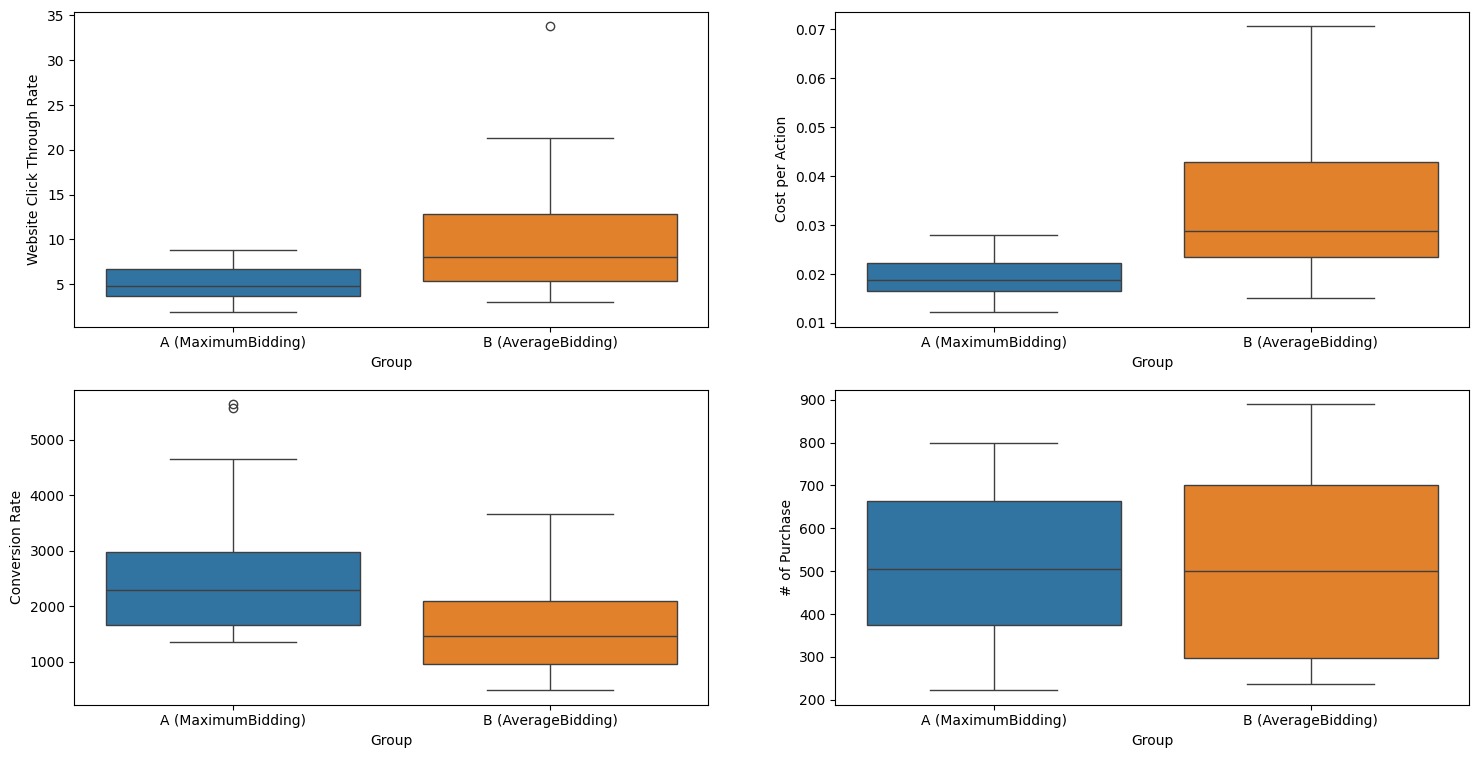

In [17]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [18]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.
controlB = data_prepare_for_hypothesis_testing(control_nop, test_nop)
controlB.head(3)

,A,B
0,618,255
1,511,677
2,372,578


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [22]:
#TODO : Aply the normality assumption of the dataframe for A
shapiro_stat, shapiro_p = stats.shapiro(controlB['A'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

# Interpret the p-value
alpha = 0.05
if shapiro_p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test: Statistic=0.9427996417799834, p-value=0.10821626663232115
Sample looks Gaussian (fail to reject H0)


In [26]:
AB.head()

,# of Purchase,Website Click Through Rate,Cost per Action,Conversion Rate,Group
0,618,8.483471,0.023602,1376.909920,A (MaximumBidding)
1,511,6.700264,0.013039,1661.578298,A (MaximumBidding)
2,372,4.941121,0.016383,2197.464659,A (MaximumBidding)
3,340,4.205659,0.024406,2593.474715,A (MaximumBidding)
4,514,5.508217,0.016464,2016.591279,A (MaximumBidding)


In [28]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
# Filter the DataFrame for group A
group_A = AB[AB['Group'] == 'A (MaximumBidding)']

# Compute the p-value for normality on the '# of Purchase' column using the Shapiro-Wilk test
shapiro_stat, p_value = stats.shapiro(group_A['# of Purchase'])

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Interpret the p-value
alpha = 0.05
if shapiro_p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample looks Gaussian (fail to reject H0)


For both columns we failed to reject null hypothesis, because p-value is higher than alpha.

In [25]:
#TODO : Aply the normality assumption of the dataframe for B
# Calculate the p-value for normality using Shapiro-Wilk test
shapiro_stat, p_value = stats.shapiro(controlB['B'])

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)
# Interpret the p-value
alpha = 0.05
if shapiro_p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Sample looks Gaussian (fail to reject H0)


In [29]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.
# Filter the DataFrame for group B
group_B = AB[AB['Group'] == 'B (AverageBidding)']

# Compute the p-value for normality on the '# of Purchase' column using the Shapiro-Wilk test
shapiro_stat, p_value = stats.shapiro(group_B['# of Purchase'])

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Interpret the p-value
alpha = 0.05
if shapiro_p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Sample looks Gaussian (fail to reject H0)


The null hipothesis isn't rejected, cause both p-values are higher than alpha

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [32]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe
# Separate the groups
group_A = AB[AB['Group'] == 'A (MaximumBidding)']['# of Purchase']
group_B = AB[AB['Group'] == 'B (AverageBidding)']['# of Purchase']

# Perform the Levene test for equality of variances
levene_stat, p_value = stats.levene(group_A, group_B)

# Print the test statistic and p-value
print(f'Levene test statistic: {levene_stat}')
print(f'P-value for Levene test: {p_value}')

# Round the p-value to three decimal places
p_value = round(p_value, 3)

# Interpret the p-value
alpha = 0.05
if p_value > alpha:
    print('Variances are homogeneous (fail to reject H0)')
else:
    print('Variances are not homogeneous (reject H0)')

Levene test statistic: 1.6899284344444696
P-value for Levene test: 0.19875304487229334
Variances are homogeneous (fail to reject H0)


In [37]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
# Perform the Levene test for equality of variances
levene_stat, p_value = stats.levene(controlB['A'], controlB['B'])

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Interpret the p-value
alpha = 0.05
if p_value > alpha:
    print('Variances are homogeneous (fail to reject H0)')
else:
    print('Variances are not homogeneous (reject H0)')
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Variances are homogeneous (fail to reject H0)


Yes, variances are homogeneous, we failed to reject H0. Cause p-value is hight than 0.05

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [35]:
# Average Biddingin (Test Group)
stats.mannwhitneyu(controlB["A"], controlB["B"])

MannwhitneyuResult(statistic=455.0, pvalue=0.9469515266277105)

In [38]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
# Separate the groups for the # of Purchase column
group_A = AB[AB['Group'] == 'A (MaximumBidding)']['# of Purchase']
group_B = AB[AB['Group'] == 'B (AverageBidding)']['# of Purchase']

# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(group_A, group_B)

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Print the test statistic and the rounded p-value
print(f'Mann-Whitney U test statistic: {statistic}')
print(f'P-value for Mann-Whitney U test (rounded to 3 decimal places): {p_value_rounded}')

# Interpret the p-value
alpha = 0.05
if p_value > alpha:
    print('There is no statistically significant difference (fail to reject H0)')
else:
    print('There is a statistically significant difference (reject H0)')
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Mann-Whitney U test statistic: 455.0
P-value for Mann-Whitney U test (rounded to 3 decimal places): 0.947
There is no statistically significant difference (fail to reject H0)


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

There is no significant difference in statistics for group A and group B.

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**
The performance of new campaign influences the averege bidding on website.


   
**2. Can we conclude statistically significant results?**
Axtually, the sample is to small - only 60 customers, for e-commerce that's quite low for statistically significant proves.

  


**3. Which statistical test did you use, and why?**
I used Shapito test for normaolity (I have normal distribution - but I suppose to have a mistake - like there is no normal distribution inside. I used Levene test for equality and varience inside the data And I used NonParametric Independent T-test
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**
To make samples more statistically significant.

   